In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

<ipython-input-9-9dd469a3f9cb>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [10]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

<ipython-input-10-f391b7cb3b7b>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [12]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# CNN

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 64)           1792      
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                                                                 
 dense (Dense)               (None, 128)               1032320   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1034499 (3.95 MB)
Trainable params: 1034499 (3.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 10s 22ms/step - loss: 0.2958 - accuracy: 0.8530 - val_loss: 0.2030 - val_accuracy: 0.9189
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1980 - accuracy: 0.9152 - val_loss: 0.1968 - val_accuracy: 0.9189
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.2094 - accuracy: 0.9125 - val_loss: 0.2075 - val_accuracy: 0.9197
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1880 - accuracy: 0.9203 - val_loss: 0.1938 - val_accuracy: 0.9148
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1834 - accuracy: 0.9206 - val_loss: 0.1829 - val_accuracy: 0.9107
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1793 - accuracy: 0.9159 - val_loss: 0.2033 - val_accuracy: 0.9009
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1741 - accuracy: 0.9203 - val_loss: 0.1825 - val_accuracy: 0.9083
Epoch 8/10
32/32 [

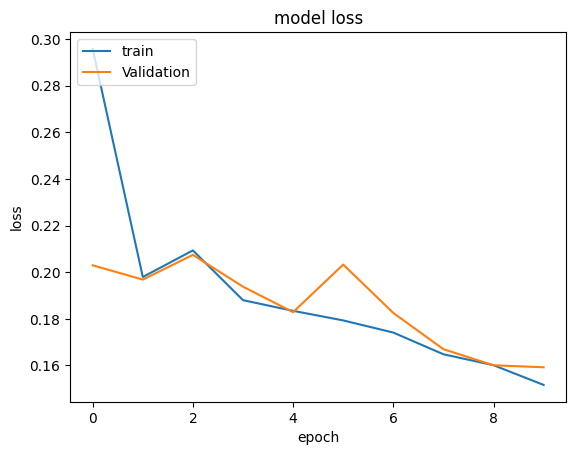

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

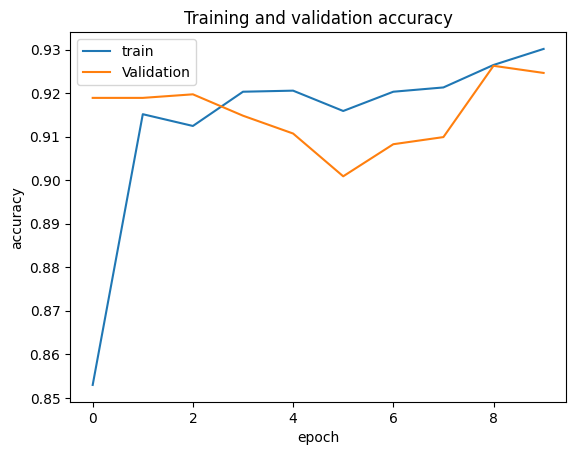

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 2ms/step
[[391 100   0]
 [ 72 460   0]
 [  0  17 520]]
0.8788461538461538
0.8795985377819237
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       491
           1       0.80      0.86      0.83       532
           2       1.00      0.97      0.98       537

    accuracy                           0.88      1560
   macro avg       0.88      0.88      0.88      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

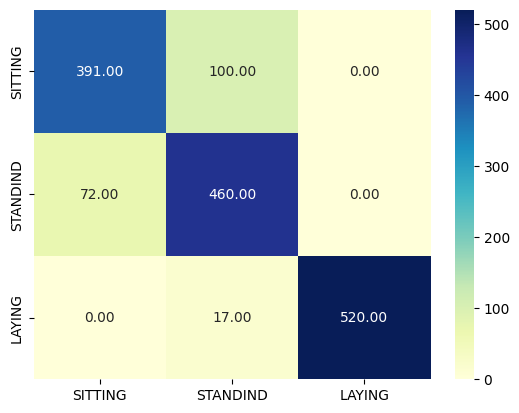

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 2



In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_2 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1015936   
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1030467 (3.93 MB)
Trainable params: 1030467 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 3s 33ms/step - loss: 0.2838 - accuracy: 0.8662 - val_loss: 0.2032 - val_accuracy: 0.9181
Epoch 2/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1970 - accuracy: 0.9112 - val_loss: 0.1966 - val_accuracy: 0.9214
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1844 - accuracy: 0.9166 - val_loss: 0.1883 - val_accuracy: 0.9115
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1908 - accuracy: 0.9139 - val_loss: 0.1920 - val_accuracy: 0.9214
Epoch 5/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1716 - accuracy: 0.9225 - val_loss: 0.1710 - val_accuracy: 0.9238
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 0.1801 - accuracy: 0.9198 - val_loss: 0.1929 - val_accuracy: 0.9173
Epoch 7/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1836 - accuracy: 0.9179 - val_loss: 0.1660 - val_accuracy: 0.9181
Epoch 8/10
32/32 [=

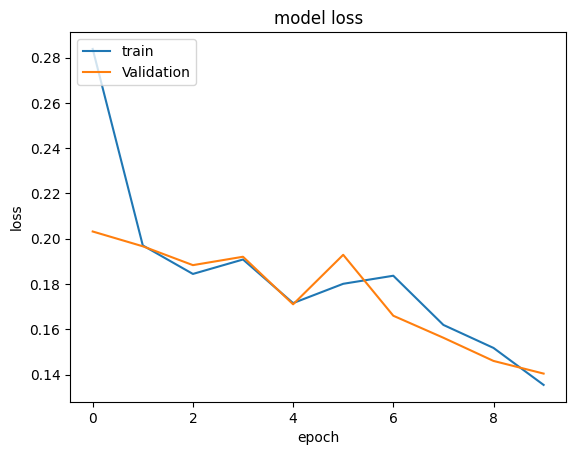

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

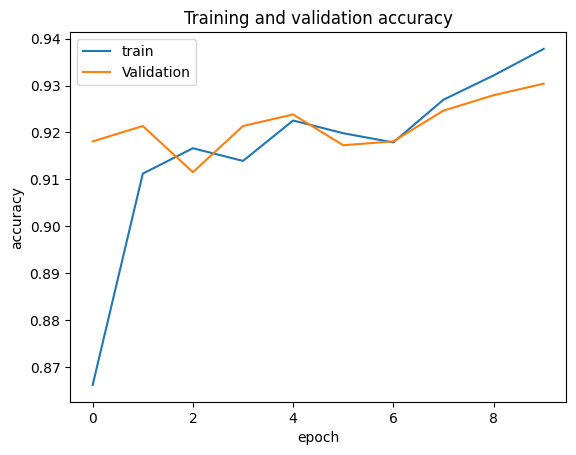

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 3ms/step
[[406  85   0]
 [ 70 462   0]
 [  0  27 510]]
0.8833333333333333
0.8845547352575461
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       491
           1       0.80      0.87      0.84       532
           2       1.00      0.95      0.97       537

    accuracy                           0.88      1560
   macro avg       0.89      0.88      0.88      1560
weighted avg       0.89      0.88      0.88      1560



<Axes: >

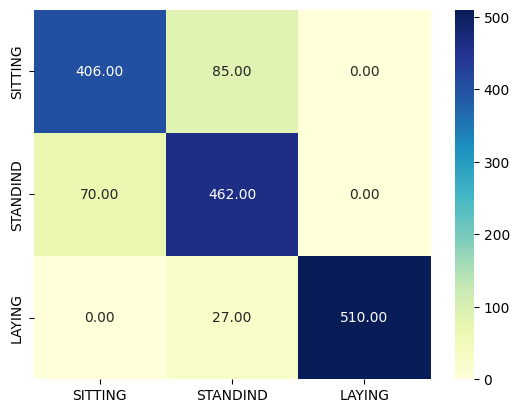

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 3

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_4 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_5 (Conv1D)           (None, 122, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 61, 64)            0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 3904)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               499840    
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 3s 24ms/step - loss: 0.3388 - accuracy: 0.8397 - val_loss: 0.2479 - val_accuracy: 0.8862
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2062 - accuracy: 0.9134 - val_loss: 0.2286 - val_accuracy: 0.8927
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1959 - accuracy: 0.9164 - val_loss: 0.1955 - val_accuracy: 0.9083
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1841 - accuracy: 0.9181 - val_loss: 0.1815 - val_accuracy: 0.9222
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1842 - accuracy: 0.9198 - val_loss: 0.2681 - val_accuracy: 0.8952
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: 0.2067 - accuracy: 0.9093 - val_loss: 0.1980 - val_accuracy: 0.9025
Epoch 7/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1783 - accuracy: 0.9225 - val_loss: 0.1743 - val_accuracy: 0.9287
Epoch 8/10
32/32 [=

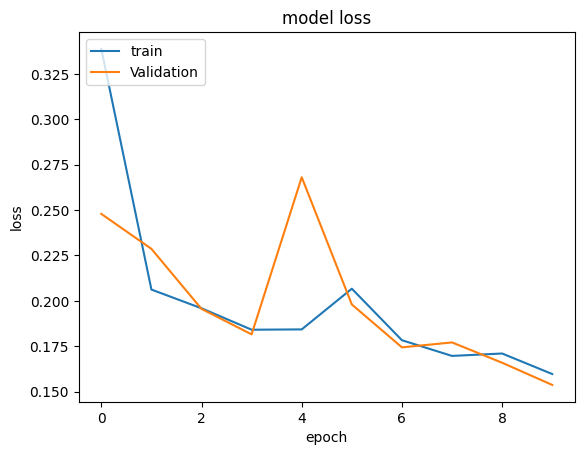

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

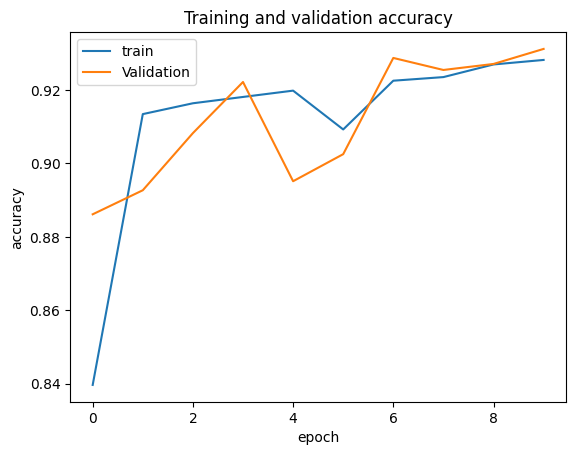

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 3ms/step
[[377 114   0]
 [ 68 464   0]
 [  0   5 532]]
0.8801282051282051
0.8799953629621406
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       491
           1       0.80      0.87      0.83       532
           2       1.00      0.99      1.00       537

    accuracy                           0.88      1560
   macro avg       0.88      0.88      0.88      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

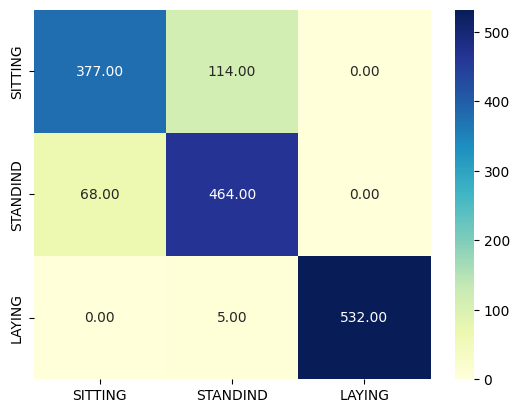

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN4

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 conv1d_7 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 conv1d_8 (Conv1D)           (None, 122, 64)           12352     
                                                                 
 conv1d_9 (Conv1D)           (None, 120, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 60, 64)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3840)              0         
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 4s 28ms/step - loss: 0.3481 - accuracy: 0.8485 - val_loss: 0.1989 - val_accuracy: 0.9222
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1950 - accuracy: 0.9137 - val_loss: 0.1872 - val_accuracy: 0.9083
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1831 - accuracy: 0.9152 - val_loss: 0.1837 - val_accuracy: 0.9230
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1750 - accuracy: 0.9238 - val_loss: 0.1855 - val_accuracy: 0.9287
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1687 - accuracy: 0.9228 - val_loss: 0.1673 - val_accuracy: 0.9165
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1652 - accuracy: 0.9235 - val_loss: 0.1677 - val_accuracy: 0.9247
Epoch 7/10
32/32 [==============================] - 0s 7ms/step - loss: 0.1687 - accuracy: 0.9272 - val_loss: 0.1529 - val_accuracy: 0.9255
Epoch 8/10
32/32 [

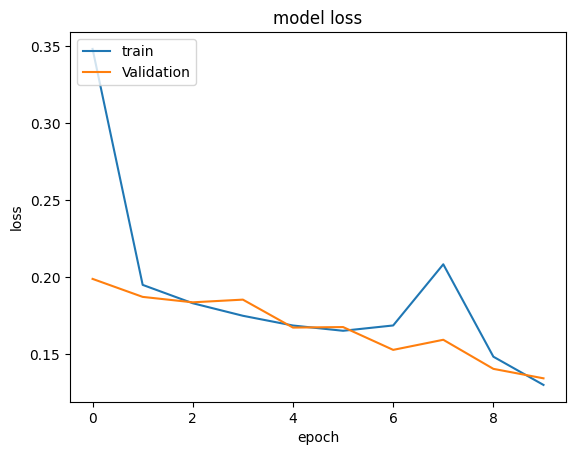

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

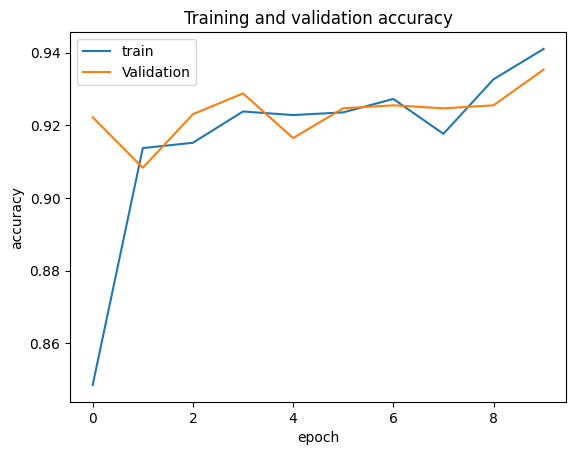

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 3ms/step
[[421  64   6]
 [ 90 442   0]
 [  0   0 537]]
0.8974358974358975
0.897233823075651
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       491
           1       0.87      0.83      0.85       532
           2       0.99      1.00      0.99       537

    accuracy                           0.90      1560
   macro avg       0.90      0.90      0.90      1560
weighted avg       0.90      0.90      0.90      1560



<Axes: >

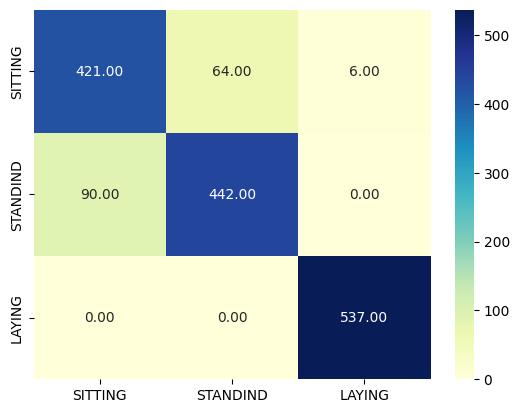

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 5

In [26]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 126, 64)           1792      
                                                                 
 conv1d_11 (Conv1D)          (None, 124, 64)           12352     
                                                                 
 conv1d_12 (Conv1D)          (None, 122, 64)           12352     
                                                                 
 conv1d_13 (Conv1D)          (None, 120, 64)           12352     
                                                                 
 conv1d_14 (Conv1D)          (None, 118, 64)           12352     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 59, 64)            0         
 g1D)                                                            
                                                      

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 2s 17ms/step - loss: 0.3615 - accuracy: 0.8448 - val_loss: 0.2457 - val_accuracy: 0.8829
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2018 - accuracy: 0.9134 - val_loss: 0.1948 - val_accuracy: 0.9042
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1911 - accuracy: 0.9186 - val_loss: 0.1840 - val_accuracy: 0.9189
Epoch 4/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1875 - accuracy: 0.9184 - val_loss: 0.1937 - val_accuracy: 0.9222
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1878 - accuracy: 0.9169 - val_loss: 0.1801 - val_accuracy: 0.9124
Epoch 6/10
32/32 [==============================] - 0s 11ms/step - loss: 0.1744 - accuracy: 0.9218 - val_loss: 0.1920 - val_accuracy: 0.9107
Epoch 7/10
32/32 [==============================] - 0s 11ms/step - loss: 0.1706 - accuracy: 0.9235 - val_loss: 0.1977 - val_accuracy: 0.9206
Epoch 8/10
32/32

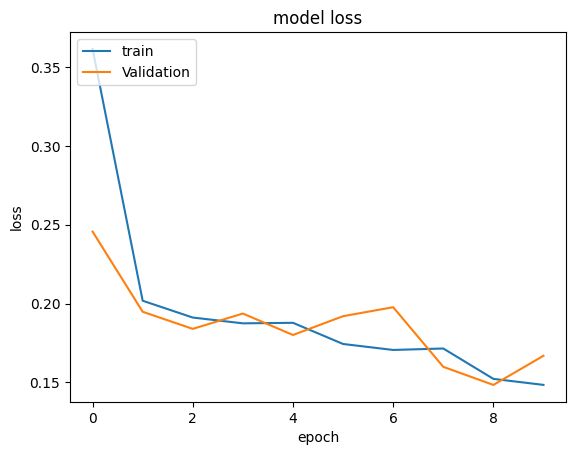

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

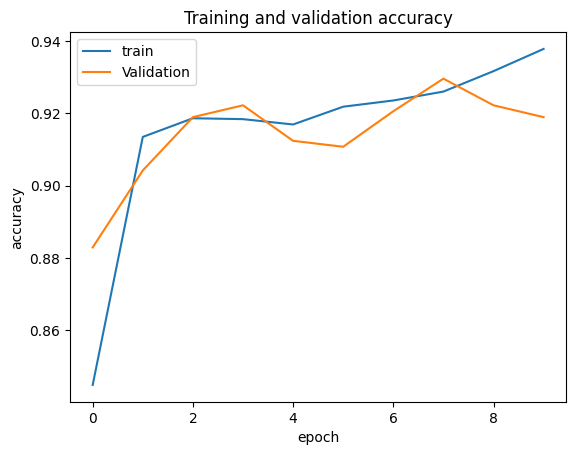

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 3ms/step
[[369 122   0]
 [ 57 475   0]
 [  0  27 510]]
0.867948717948718
0.8689134856355392
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       491
           1       0.76      0.89      0.82       532
           2       1.00      0.95      0.97       537

    accuracy                           0.87      1560
   macro avg       0.88      0.86      0.87      1560
weighted avg       0.88      0.87      0.87      1560



<Axes: >

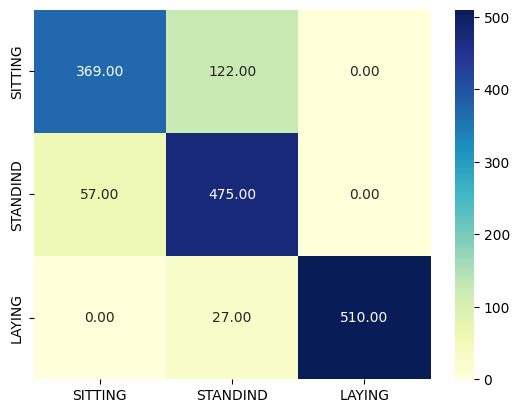

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')